In [1]:
import numpy as np
import os
import glob

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm.notebook import tqdm

from scipy.io import loadmat 
from scipy.spatial import distance_matrix
from scipy.stats import ranksums, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LinearRegression

import itertools

In [2]:
plt.rcParams["font.family"] = "Arial" 
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams["svg.fonttype"] = "none"

def stat_annot_h(ax, x1, x2, y, h, color="k", text=r"$\ast$"):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color, clip_on=False)
    ax.text((x1+x2)*.5, y+h, text, ha='center', va='bottom', color=color, clip_on=False)

## load analysis results

In [3]:
genres_label = ['animation', 'nature', 'drama']
genres = ['cartoon/animation', 'doc/nature', 'drama/other']
embed_dims = [2, 32]

gen_idx = 0 # 0-2
gen = genres_label[gen_idx]
gen_name = genres[gen_idx]
mds_dist_dicts = {}
for d in embed_dims:
    mds_dist_dicts[str(d)] = np.load(f"../results/mds_dist_CW2019_{gen}_dim{d}.npz", allow_pickle=True)

In [4]:
mds_centered_dict = mds_dist_dicts["2"]["mds_centered"].item()
mds_dist_dict = mds_dist_dicts["32"]["mds_dist"].item()
mds_dist_min_dict = mds_dist_dicts["32"]["mds_dist_min"].item()
mds_dist_flatten_dict = mds_dist_dicts["32"]["mds_dist_flatten"].item()

In [5]:
training_methods = ["dino", "supervised"] 
depth_list = [4, 8, 12]
num_models = 6

## Group comparison of MDS distance

In [6]:
# Subjects
mds_dist_groups_dict = {}
mds_dist_groups_dict["subj"] = mds_dist_dict["subj"]

# ViTs
for tm in training_methods:
    for depth in depth_list:
        top5 = np.sort(mds_dist_dict[tm][str(depth)].reshape(6, -1), axis=1)[:, :5].flatten()
        mds_dist_groups_dict[f"{tm}_{depth}"] = top5
        #mds_dist_groups_dict[f"{tm}_{depth}"] = mds_dist_min_dict[tm][str(depth)]
        
    top5 = np.sort(mds_dist_dict[f"{tm}_deit_small16"].flatten())[:5]
    mds_dist_groups_dict[f"{tm}_deit_small16"] = top5 #mds_dist_min_dict[f"{tm}_deit_small16"]
        
# GBVS
mds_dist_groups_dict["gbvs"] = mds_dist_dict["gbvs"]

In [7]:
df_mds_dist_groups = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in mds_dist_groups_dict.items()]))
df_mds_dist_groups = df_mds_dist_groups.drop([f"{tm}_deit_small16" for tm in training_methods], axis=1)

In [8]:
df_mds_dist_groups = df_mds_dist_groups.rename(columns={'subj': 'Participants',
                                        'dino_4': 'DINO ViT-4', 'dino_8': 'DINO ViT-8', 'dino_12': 'DINO ViT-12', 
                                        'supervised_4': 'SL ViT-4', 'supervised_8': 'SL ViT-8', 'supervised_12': 'SL ViT-12',
                                        'gbvs': 'GBVS'})

In [9]:
mds_saliency = df_mds_dist_groups["GBVS"].to_numpy()[:7]
saliency_labels = ["All", "Intensity", "Orientation", "Contrast", "Flicker", "Motion", "Color (DKL)"]

In [10]:
pairs = []
pairs_num = []
n_col = len(df_mds_dist_groups.columns)
for j in range(1, n_col):
    pairs.append((df_mds_dist_groups.columns[0], df_mds_dist_groups.columns[j]))
    pairs_num.append((0, j))
"""
for j in range(1, n_col):
    if j != 3:
        pairs.append((df_mds_dist_groups.columns[3], df_mds_dist_groups.columns[j]))
        pairs_num.append((3, j))    
"""

'\nfor j in range(1, n_col):\n    if j != 3:\n        pairs.append((df_mds_dist_groups.columns[3], df_mds_dist_groups.columns[j]))\n        pairs_num.append((3, j))    \n'

In [11]:
pairs

[('Participants', 'DINO ViT-4'),
 ('Participants', 'DINO ViT-8'),
 ('Participants', 'DINO ViT-12'),
 ('Participants', 'SL ViT-4'),
 ('Participants', 'SL ViT-8'),
 ('Participants', 'SL ViT-12'),
 ('Participants', 'GBVS')]

In [12]:
len(pairs)

7

In [13]:
def delete_nan(arr):
    return arr[~np.isnan(arr)]

In [14]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [15]:
p_values = []
for pair in pairs:
    s, p = mannwhitneyu(delete_nan(df_mds_dist_groups[pair[0]]), delete_nan(df_mds_dist_groups[pair[1]]), 
                        alternative="two-sided", method="exact")
    p_values.append(p)

In [16]:
p_values = np.array(p_values)

In [17]:
#reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='holm')
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='bonferroni')
#reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(p_values, alpha=0.05, method='fdr_bh') #'holm') 

In [18]:
indices = [i for i, x in enumerate(~reject) if x] # not significance indicces
ns_pairs = [pairs[i] for i in indices]
ns_pairs_num = [pairs_num[i] for i in indices]

In [19]:
for i, pair in enumerate(pairs):
    print(pair, pvals_corrected[i], convert_pvalue_to_asterisks(pvals_corrected[i]))

('Participants', 'DINO ViT-4') 2.974745778265503e-14 ****
('Participants', 'DINO ViT-8') 1.8591889753072323e-12 ****
('Participants', 'DINO ViT-12') 2.466508176447634e-12 ****
('Participants', 'SL ViT-4') 7.637624835589692e-23 ****
('Participants', 'SL ViT-8') 3.2332611803996364e-21 ****
('Participants', 'SL ViT-12') 5.82368893713714e-21 ****
('Participants', 'GBVS') 8.502014456894787e-06 ****


In [20]:
num_class = [1, 3, 3, 1]
num_group = np.sum(num_class)
group_ids = np.hstack([np.repeat(i, num_class[i]) for i in range(len(num_class))])
group_pos = np.arange(num_group) + group_ids * 0.5

In [21]:
df_mds_dist_groups_n = df_mds_dist_groups.copy()
df_mds_dist_groups_n.columns = group_pos
df_mds_dist_groups_melt = df_mds_dist_groups_n.melt()
df_mds_dist_groups_melt = df_mds_dist_groups_melt.dropna()

In [22]:
cmap_cb = sns.color_palette("colorblind")
#cmap = sns.color_palette("bright")
cmap = sns.color_palette("tab10")
#cmap = mpl.colormaps.get_cmap('tab10')

In [23]:
subj_labels = ["Participants"]
subj_colors = [cmap[3]]
subj_markers = ["o"]
model_labels = [["DINO ViT-4", "DINO ViT-8", "DINO ViT-12"], ["SL ViT-4", "SL ViT-8", "SL ViT-12"]]
model_colors = [[cmap_cb[9] for j in range(3)], [cmap_cb[2] for j in range(3)], [cmap_cb[7]]]
model_markers = ["P", "s", "D"]

In [24]:
color_list = subj_colors + list(itertools.chain.from_iterable(model_colors))

In [25]:
color_pal = {}
for i, key in enumerate(group_pos):
    color_pal[key] = color_list[i]

xo = np.arange(0, group_pos.max()+0.5, 0.5)

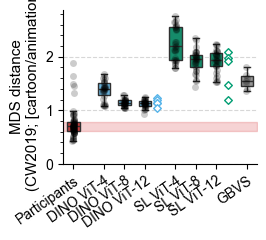

In [27]:
fig, ax = plt.subplots(figsize=(2.5, 2))
sns.boxplot(data=df_mds_dist_groups_melt, palette=color_pal, 
            x="variable", y="value", hue="variable", order=xo, showfliers=False, legend=False,
            width=1.2, ax=ax)
#vit_official_indices = df_mds_dist_groups_melt["value"].isin([mds_min_all_dist_dict[tm]["12"][-1] for tm in training_methods])
sns.stripplot(data=df_mds_dist_groups_melt, x="variable", y="value", color="k", 
              alpha=0.2, ax=ax, rasterized=False)

ax.scatter([8.2]*5, mds_dist_groups_dict["dino_deit_small16"][::-1], 
           fc="white", ec=model_colors[0][0],
           marker="D", label="Official ViT-12", alpha=1, s=15)
ax.scatter([15.2]*5, mds_dist_groups_dict["supervised_deit_small16"][::-1], 
           fc="white", ec=model_colors[1][0], 
           marker="D", label=" ",alpha=1, s=15)
#official = df_mds_dist_groups_melt[vit_official_indices].to_numpy()
#ax.scatter(official[:, 0]*2, official[:, 1], marker="P", color="tab:red", 
#           alpha=1, rasterized=True, zorder=999)
#ax.scatter(official[:, 0]*2, official[:, 1], marker="o", color="tab:red", 
#           alpha=1, s=20, rasterized=True, zorder=999)
"""
for i in range(len(group_pos)-1):
    ax.text(group_pos[i+1]*2, 170, convert_pvalue_to_asterisks(pvals_corrected[i]),
            fontsize=12, va="center", ha="center")
"""
ax.fill_between([-1, len(xo)], 
                np.percentile(df_mds_dist_groups["Participants"].dropna().values, 25),
                np.percentile(df_mds_dist_groups["Participants"].dropna().values, 75),
                color=color_list[0], alpha=0.2, label="TD adults IQR", zorder=-1)
for i, pair in enumerate(pairs_num):
    x1, x2 = pair
    y = 170
    h = 5
    text = convert_pvalue_to_asterisks(pvals_corrected[i])
    p = pvals_corrected[i]
    if p > 0.01:
        stat_annot_h(ax, group_pos[x1]*2, group_pos[x2]*2, y, h, color="k", text=text)
        #stat_annot_h(ax, group_pos[x1]*2, group_pos[x2]*2, y, h, color="k", text=r"$p=$"+f"{p:.4f}")
ax.set_xticks(ticks=group_pos*2)
ax.set_xticklabels(list(df_mds_dist_groups.columns), rotation=35, ha="right", rotation_mode='anchor')
ax.set_xlim(-1, len(xo))
ax.grid(linestyle='--', alpha=0.5, axis='y')
ax.set_ylabel(f"MDS distance\n(CW2019; [{gen_name}])", fontsize=11)
#ax.legend(ncol=2, handletextpad=0, columnspacing=1, prop={'size': 9}, labelspacing=0.1)
ax.set_xlabel("")
#for i in range(len(mds_saliency)):
#    ax.text(24, mds_saliency[i], saliency_labels[i], va="center", fontsize=9, rotation=35, rotation_mode='anchor')
ax.minorticks_on()
ax.xaxis.set_tick_params(which='minor', bottom=False)
#ax.set_ylim(0, 210)
ax.set_ylim(0, )
#plt.savefig("../figures/MDS_boxplot_compare_groups_N2010.svg", dpi=300, bbox_inches="tight")
plt.savefig(f"../figures/MDS_boxplot_compare_groups_CW2019_{gen}.svg", bbox_inches='tight', dpi=300)

## Group comparison of MDS plot

In [28]:
vit_mds_min_pos_dict = {}
for tm in training_methods:
    for depth in depth_list:
        vit_mds_min_pos_dict[f"{tm}_{depth}"] = []
        for i in range(len(mds_dist_min_dict[tm][str(depth)])):
            m_idx, d_idx, h_idx = np.argwhere(mds_dist_dict[tm][str(depth)] == mds_dist_min_dict[tm][str(depth)][i])[0]
            vit_mds_min_pos_dict[f"{tm}_{depth}"].append(mds_centered_dict[tm][str(depth)][m_idx, d_idx, h_idx, :])
        vit_mds_min_pos_dict[f"{tm}_{depth}"] = np.array(vit_mds_min_pos_dict[f"{tm}_{depth}"])
    # official model
    d_idx, h_idx = np.argwhere(mds_dist_dict[f"{tm}_deit_small16"] == mds_dist_min_dict[f"{tm}_deit_small16"])[0]
    vit_mds_min_pos_dict[f"{tm}_deit_small16"] = mds_centered_dict[f"{tm}_deit_small16"][d_idx, h_idx, :]

In [29]:
def plot_mds(ax, mds_centered_dict, text=False, rasterized=False):
    ax.scatter(mds_centered_dict["subj"][:, 0], mds_centered_dict["subj"][:, 1], 
               color="tab:red", marker="o", label="Participants", alpha=1, rasterized=rasterized)

    for i, tm in enumerate(training_methods):
        for j, depth in enumerate(depth_list):
            model_mds = vit_mds_min_pos_dict[f"{tm}_{depth}"]
            if depth == 12:
                ax.scatter(model_mds[:-1, 0], model_mds[:-1, 1],
                           color=model_colors[i][j], marker=model_markers[j], 
                           label=model_labels[i][j], alpha=1, rasterized=rasterized)            
                ax.scatter(model_mds[-1, 0], model_mds[-1, 1],
                           fc="white", ec=model_colors[i][j], marker="D", 
                           label="Official ViT-12", alpha=1, zorder=3)            
            else:
                ax.scatter(model_mds[:, 0], model_mds[:, 1],
                           color=model_colors[i][j], marker=model_markers[j], 
                           label=model_labels[i][j], alpha=1, rasterized=rasterized)                
    ax.scatter(mds_centered_dict["gbvs"][:, 0], mds_centered_dict["gbvs"][:, 1], marker="v", 
               color=cmap[7], label="GBVS", alpha=1, zorder=-1)
    if text:
        for k in range(len(saliency_labels)):
            ax.text(mds_centered_dict["gbvs"][k, 0], mds_centered_dict["gbvs"][k, 1], 
                    saliency_labels[k], ha="left", va="center", fontsize=9)
    ax.axvline(x=0, linestyle="dashed", alpha=0.5, color="k", zorder=-1)
    ax.axhline(y=0, linestyle="dashed", alpha=0.5, color="k", zorder=-1)
    ax.minorticks_on()
    #ax.set_aspect('equal', adjustable='box')

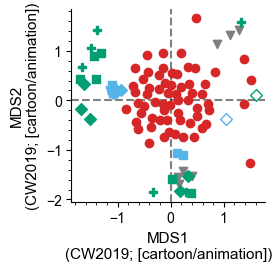

In [30]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
plot_mds(ax, mds_centered_dict, text=False, rasterized=False)
"""
ta.allocate_text(fig,ax,gbvs_mds_centered[:, 0],gbvs_mds_centered[:, 1],
                 saliency_labels,
                 x_scatter=scatter_all[:, 0], y_scatter=scatter_all[:, 1],
                 textsize=9, margin=0.05,
                min_distance=0.005)
"""
ax.set_xlabel(f"MDS1\n(CW2019; [{gen_name}])", fontsize=11)
ax.set_ylabel(f"MDS2\n(CW2019; [{gen_name}])", fontsize=11)
#ax.set_facecolor("#EAEAF2")
"""
x1, x2, y1, y2 = -50, 50, -50, 50  # subregion of the original image
axins = ax.inset_axes(
    [1.1, 0.02, 0.7, 0.7],
    xlim=(x1, x2), ylim=(y1, y2))
plot_mds(axins, text=False)
axins.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.3, 1.6), prop={'size': 9},
             handletextpad=0, columnspacing=0.5)
"""
#ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.0), prop={'size': 9},
#          handletextpad=0, columnspacing=0.5)
#ax.indicate_inset_zoom(axins, edgecolor="black")
#fig.tight_layout()
fig.savefig(f"../figures/MDS_2d_CW2019_{gen}.svg", bbox_inches='tight', dpi=300)

## Layer comparison of MDS distance

In [31]:
from matplotlib import ticker

In [32]:
from matplotlib.ticker import ScalarFormatter

In [33]:
"""
fig, axes = plt.subplots(2, 3, figsize=(5, 3.2), sharex='col', sharey='all', width_ratios=[1, 2, 3], tight_layout=True)
#fig.suptitle("All data")
for i, tm in enumerate(training_methods):
    for j, depth in enumerate(depth_list):
        dist_mat = mds_dist_flatten_dict[tm][str(depth)]
        #dist_mat_min = np.min(dist_mat, axis=2)
        columns = [str(d+1) for d in range(depth)]
        df = pd.DataFrame(dist_mat, columns=columns)#, columns=np.array2string(np.arange(1, depth+1)))
        df_melt = df.melt()
        vit_min_indices = df_melt["value"].isin(mds_dist_min_dict[tm][str(depth)])
        #vit_min_indices = df_melt["value"].isin(mds_dist_groups_dict[f"{tm}_{depth}"])
        
        
        #sns.stripplot(data=df, jitter=True, linewidth=1, edgecolor='k', palette=colors[i], ax=axes[i, j])
        #axes[i, j].grid(linestyle='--', linewidth=1)
        dist_median = np.median(dist_mat, axis=0)
        dist_median_minidx = np.argmin(dist_median)
        #axes[i, j].arrow(dist_median_minidx, dist_mat[:, dist_median_minidx].max()+90, 0, -30, 
        #                 head_width=0.2, head_length=20, color="tab:red", zorder=999, clip_on=False)
        #sns.pointplot(data=df_melt, x="variable", y="value", estimator='median', ax=axes[i, j], 
        #              color=cmaps[i](0.2*(j+2)), errorbar=("pi", 50), linewidth=2, zorder=9)#showfliers=False, color="white", width=0.6, 
        #axes[i, j].scatter(np.arange(0, len(dist_median)), dist_median, color="white", marker="o", s=6, zorder=10)
        axes[i, j].scatter(dist_median_minidx, dist_median[dist_median_minidx], color="k", marker=".", s=10, zorder=11)

        sns.boxplot(data=df_melt, x="variable", y="value", showfliers=False, color="0.9", width=0.6, 
                    ax=axes[i, j], linecolor="k")
        #sns.boxplot(data=df_melt, x="variable", y="value", showfliers=False, color=model_colors[i][j], width=0.6, 
        #            ax=axes[i, j])
        axes[i, j].plot(np.arange(0, len(dist_median)), dist_median, color=model_colors[i][j], 
                        linewidth = 2.0, marker="o", ms=6, mec="k", mfc="white", zorder=10)
        sns.stripplot(data=df_melt[~vit_min_indices], x="variable", y="value", color="k", alpha=0.2, ax=axes[i, j], rasterized=False)
        axes[i, j].scatter(df_melt[vit_min_indices]["variable"].to_numpy().astype(float) -1 + (np.random.rand(num_models)-0.5)/3, 
                           df_melt[vit_min_indices]["value"].to_numpy().astype(float), 
                           marker=model_markers[j], facecolor=model_colors[i][j], linewidth=0.5, alpha=0.8, zorder=3, 
                           label="Model-best heads")
        official_min_idx = np.where(mds_dist_dict[f"{tm}_deit_small16"] == mds_dist_min_dict[f"{tm}_deit_small16"])[0]
        if j == 2:
            axes[i, j].scatter(official_min_idx+0.3, mds_dist_min_dict[f"{tm}_deit_small16"], 
                               ec=model_colors[i][j], fc="white", linewidth=0.5, marker="D", alpha=1, zorder=5, label="Official model-best heads")
        if tm == "dino":
            tm_ = "DINO ViT-"
        else:
            tm_ = "SL ViT-"
        axes[i, j].set_title(f"{tm_}{depth}", fontsize=11)
        #xes[i, j].axhline(subj_mean_dist, linestyle="dashed", color="tab:red", label="Dist. between subjects")
        #if i == 0 and j == 2:
        #    axes[i, j].legend()
        axes[i, j].minorticks_on()
        axes[i, j].grid(which='major', alpha=0.5, axis="y")
        #axes[i, j].grid(which='minor', alpha=0.5, linestyle='--', axis="y")

        axes[i, j].xaxis.set_tick_params(which='minor', bottom=False)
        axes[i, j].set_yscale('log')
        #axes[i, j].set_ylim(20, )# 450)
        axes[i, j].set_xlim(-0.5, depth-0.5)
        axes[i, j].set_xlabel("")
        axes[i, j].set_ylabel("")
        axes[i, j].yaxis.set_major_formatter(ScalarFormatter())
        axes[i, j].yaxis.set_minor_formatter(ticker.NullFormatter())
        axes[i, j].set_yticks([0.6, 1,2,4,6])
        axes[i, j].fill_between([-0.5, depth-0.5], 
                        np.percentile(df_mds_dist_groups["Participants"].dropna().values, 25),
                        np.percentile(df_mds_dist_groups["Participants"].dropna().values, 75),
                        color=color_list[0], alpha=0.2, label="TD adults IQR", zorder=-1)
        
#axes[0, 2].legend(ncol=2, handletextpad=0, prop={'size': 9}, borderpad=0.3, labelspacing=0.1)
axes[1, 1].set_xlabel("# layers")
axes[1, 0].set_ylabel(f"MDS distance\n(CW2019; [{gen_name}])")
plt.savefig(f"../figures/MDS_dist_layers_CW2019_{gen}.svg", bbox_inches='tight', dpi=300)
#plt.savefig("../figures/MDS_dist_layers_N2010.svg", dpi=300, bbox_inches="tight")
fig.show()
"""

'\nfig, axes = plt.subplots(2, 3, figsize=(5, 3.2), sharex=\'col\', sharey=\'all\', width_ratios=[1, 2, 3], tight_layout=True)\n#fig.suptitle("All data")\nfor i, tm in enumerate(training_methods):\n    for j, depth in enumerate(depth_list):\n        dist_mat = mds_dist_flatten_dict[tm][str(depth)]\n        #dist_mat_min = np.min(dist_mat, axis=2)\n        columns = [str(d+1) for d in range(depth)]\n        df = pd.DataFrame(dist_mat, columns=columns)#, columns=np.array2string(np.arange(1, depth+1)))\n        df_melt = df.melt()\n        vit_min_indices = df_melt["value"].isin(mds_dist_min_dict[tm][str(depth)])\n        #vit_min_indices = df_melt["value"].isin(mds_dist_groups_dict[f"{tm}_{depth}"])\n        \n        \n        #sns.stripplot(data=df, jitter=True, linewidth=1, edgecolor=\'k\', palette=colors[i], ax=axes[i, j])\n        #axes[i, j].grid(linestyle=\'--\', linewidth=1)\n        dist_median = np.median(dist_mat, axis=0)\n        dist_median_minidx = np.argmin(dist_median)\n 

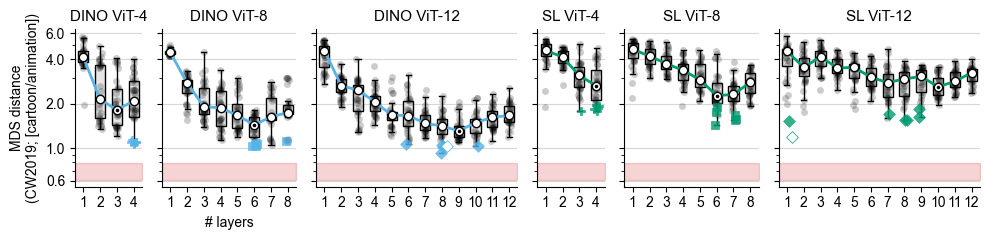

In [35]:
fig, axes = plt.subplots(1, 6, figsize=(10, 2.5), sharex='col', sharey='all', width_ratios=[1, 2, 3, 1, 2, 3], tight_layout=True)
#fig.suptitle("All data")
for i, tm in enumerate(training_methods):
    for j, depth in enumerate(depth_list):
        ij = i*len(depth_list) + j
        dist_mat = mds_dist_flatten_dict[tm][str(depth)]
        #dist_mat_min = np.min(dist_mat, axis=2)
        columns = [str(d+1) for d in range(depth)]
        df = pd.DataFrame(dist_mat, columns=columns)#, columns=np.array2string(np.arange(1, depth+1)))
        df_melt = df.melt()
        vit_min_indices = df_melt["value"].isin(mds_dist_min_dict[tm][str(depth)])
        #vit_min_indices = df_melt["value"].isin(mds_dist_groups_dict[f"{tm}_{depth}"])
        
        
        #sns.stripplot(data=df, jitter=True, linewidth=1, edgecolor='k', palette=colors[i], ax=axes[ij])
        #axes[ij].grid(linestyle='--', linewidth=1)
        dist_median = np.median(dist_mat, axis=0)
        dist_median_minidx = np.argmin(dist_median)
        #axes[ij].arrow(dist_median_minidx, dist_mat[:, dist_median_minidx].max()+90, 0, -30, 
        #                 head_width=0.2, head_length=20, color="tab:red", zorder=999, clip_on=False)
        #sns.pointplot(data=df_melt, x="variable", y="value", estimator='median', ax=axes[ij], 
        #              color=cmaps[i](0.2*(j+2)), errorbar=("pi", 50), linewidth=2, zorder=9)#showfliers=False, color="white", width=0.6, 
        #axes[ij].scatter(np.arange(0, len(dist_median)), dist_median, color="white", marker="o", s=6, zorder=10)
        axes[ij].scatter(dist_median_minidx, dist_median[dist_median_minidx], color="k", marker=".", s=10, zorder=11)

        sns.boxplot(data=df_melt, x="variable", y="value", showfliers=False, color="0.9", width=0.6, 
                    ax=axes[ij], linecolor="k")
        #sns.boxplot(data=df_melt, x="variable", y="value", showfliers=False, color=model_colors[i][j], width=0.6, 
        #            ax=axes[ij])
        axes[ij].plot(np.arange(0, len(dist_median)), dist_median, color=model_colors[i][j], 
                        linewidth = 2.0, marker="o", ms=6, mec="k", mfc="white", zorder=10)
        sns.stripplot(data=df_melt[~vit_min_indices], x="variable", y="value", color="k", alpha=0.2, ax=axes[ij], rasterized=False)
        axes[ij].scatter(df_melt[vit_min_indices]["variable"].to_numpy().astype(float) -1 + (np.random.rand(num_models)-0.5)/3, 
                           df_melt[vit_min_indices]["value"].to_numpy().astype(float), 
                           marker=model_markers[j], facecolor=model_colors[i][j], linewidth=0.5, alpha=0.8, zorder=3, 
                           label="Model-best heads")
        official_min_idx = np.where(mds_dist_dict[f"{tm}_deit_small16"] == mds_dist_min_dict[f"{tm}_deit_small16"])[0]
        if j == 2:
            axes[ij].scatter(official_min_idx+0.3, mds_dist_min_dict[f"{tm}_deit_small16"], 
                               ec=model_colors[i][j], fc="white", linewidth=0.5, marker="D", alpha=1, zorder=5, label="Official model-best heads")
        if tm == "dino":
            tm_ = "DINO ViT-"
        else:
            tm_ = "SL ViT-"
        axes[ij].set_title(f"{tm_}{depth}", fontsize=11)
        #xes[ij].axhline(subj_mean_dist, linestyle="dashed", color="tab:red", label="Dist. between subjects")
        #if i == 0 and j == 2:
        #    axes[ij].legend()
        axes[ij].minorticks_on()
        axes[ij].grid(which='major', alpha=0.5, axis="y")
        #axes[ij].grid(which='minor', alpha=0.5, linestyle='--', axis="y")

        axes[ij].xaxis.set_tick_params(which='minor', bottom=False)
        axes[ij].set_yscale('log')
        #axes[ij].set_ylim(20, )# 450)
        axes[ij].set_xlim(-0.5, depth-0.5)
        axes[ij].set_xlabel("")
        axes[ij].set_ylabel("")
        axes[ij].yaxis.set_major_formatter(ScalarFormatter())
        axes[ij].yaxis.set_minor_formatter(ticker.NullFormatter())
        axes[ij].set_yticks([0.6, 1,2,4,6])
        axes[ij].fill_between([-0.5, depth-0.5], 
                        np.percentile(df_mds_dist_groups["Participants"].dropna().values, 25),
                        np.percentile(df_mds_dist_groups["Participants"].dropna().values, 75),
                        color=color_list[0], alpha=0.2, label="TD adults IQR", zorder=-1)
        
#axes[0, 2].legend(ncol=2, handletextpad=0, prop={'size': 9}, borderpad=0.3, labelspacing=0.1)
axes[1].set_xlabel("# layers")
axes[0].set_ylabel(f"MDS distance\n(CW2019; [{gen_name}])")
plt.savefig(f"../figures/MDS_dist_layers_CW2019_{gen}.svg", bbox_inches='tight', dpi=300)
#plt.savefig("../figures/MDS_dist_layers_N2010.svg", dpi=300, bbox_inches="tight")
fig.show()